# S32407- Learn how to use GPU's for more Accurate Backtesting of Equity Investment Strategies, NVIDIA

## Part 2: Adding Price Sampling and Running Top Sharpe Ratio strategy on 12 quarters

[Mark J. Bennett, Ph.D., contact info: mbennett@nvidia.com]
[Financial Analytics book website](http://cambridge.org/FAR)

In [1]:
import cudf,pandas as pd,sys
import cupy,numpy as np,math
from numba import cuda
import warnings
warnings.filterwarnings('ignore')

### Pick a pair of months approx 3 months apart: first month is to look back 3 year daily prices

In [2]:
blockSz = 256
cupy.random.seed(100)

fname1 = "data/MVO3.2017.08/NYSE/prices.csv"
fname2 = "data/MVO3.2017.08/NASDAQ/prices.csv"

fname1 = "data/MVO3.2017.11/NYSE/prices.csv"
fname2 = "data/MVO3.2017.11/NASDAQ/prices.csv"

fname1 = "data/MVO3.2018.02/NYSE/prices.csv"
fname2 = "data/MVO3.2018.02/NASDAQ/prices.csv"

fname1 = "data/MVO3.2018.05/NYSE/prices.csv"
fname2 = "data/MVO3.2018.05/NASDAQ/prices.csv"

fname1 = "data/MVO3.2018.08/NYSE/prices.csv"
fname2 = "data/MVO3.2018.08/NASDAQ/prices.csv"

fname1 = "data/MVO3.2018.11/NYSE/prices.csv"
fname2 = "data/MVO3.2018.11/NASDAQ/prices.csv"

fname1 = "data/MVO3.2019.02/NYSE/prices.csv"
fname2 = "data/MVO3.2019.02/NASDAQ/prices.csv"

fname1 = "data/MVO3.2019.05/NYSE/prices.csv"
fname2 = "data/MVO3.2019.05/NASDAQ/prices.csv"

fname1 = "data/MVO3.2019.08/NYSE/prices.csv"
fname2 = "data/MVO3.2019.08/NASDAQ/prices.csv"

fname1 = "data/MVO3.2019.11/NYSE/prices.csv"
fname2 = "data/MVO3.2019.11/NASDAQ/prices.csv"

fname1 = "data/MVO3.2020.02/NYSE/prices.csv"
fname2 = "data/MVO3.2020.02/NASDAQ/prices.csv"

fname1 = "data/MVO3.2020.05/NYSE/prices.csv"
fname2 = "data/MVO3.2020.05/NASDAQ/prices.csv"

fname1 = "data/MVO3.2020.05/NYSE/prices.csv"
fname2 = "data/MVO3.2020.05/NASDAQ/prices.csv"

def readPrices():
    #read NYSE and NASDAQ: 2 separate price files
    df1 = cudf.read_csv(fname1)
    df2 = cudf.read_csv(fname2)
    #need to check for dup cols:
    print(list(set(df1.columns) & set(df2.columns)))
    return cudf.concat([df1, df2], axis=1)

#merge the ticker label sets:
df = readPrices()
pp = df.shape[1]
prices = df.values
cols  = df.columns.values.tolist()
print(df.shape)
df.head()

[]
(753, 4266)


,CTBB,DY,ADM,NPV,SQNS,HMN,VEC,FRC,CABO,DTY,...,TWIN,PPBI,CHI,VERI,TAYD,INTU,ICPT,ICCC,SNBR,ESGR
0,19.840122,82.209999,37.350555,11.309561,18.559999,34.581223,29.48,90.715340,695.370361,21.640013,...,17.320000,31.498922,7.924263,13.02,13.33,135.759232,108.519997,6.16,28.580000,187.800003
1,19.864172,84.190002,36.880455,11.352399,17.879999,34.401344,29.50,89.673515,698.392883,21.516924,...,17.900000,31.360567,7.910157,13.05,13.26,136.331146,111.900002,6.18,28.799999,187.649994
2,19.904253,86.690002,37.093327,11.369538,18.080000,34.491276,30.00,92.409500,709.899963,21.631811,...,18.230000,32.236824,7.973611,13.28,13.00,137.000046,113.199997,6.17,30.200001,190.550003
3,19.960365,85.959999,37.448124,11.395241,17.680000,35.300720,29.98,91.494270,710.444214,21.664639,...,18.309999,32.236824,8.008859,13.29,13.00,138.434662,119.220001,6.26,29.809999,193.800003
4,19.904253,86.889999,37.199757,11.378107,17.600000,34.806065,29.74,92.467903,705.079468,21.615398,...,18.100000,32.236824,8.008859,13.07,12.91,138.279526,120.989998,6.26,29.950001,195.600006


### Above we see a 5 row slice of our single quarter (approx. 756 days) of prices

### Below we have our Sampling code using the Block-Boostrap algorithm

In [3]:
#The following two functions were authored by Yi Dong, Ph.D. yidong@nvidia.com
@cuda.jit
def boot_strap(result, ref, block_size, sample, length, assets, num_positions, positions):
    i = cuda.threadIdx.x
    sample_id = cuda.blockIdx.x // num_positions
    position_id = cuda.blockIdx.x % num_positions
    sample_at = positions[cuda.blockIdx.x]
    for k in range(i, block_size*assets, cuda.blockDim.x):
        asset_id = k // block_size
        loc = k % block_size
        #print(sample_id, position_id, sample_at, k, asset_id, loc, position_id)
        #print(sample_id * length * assets + asset_id * length + position_id * block_size + loc + 1,  asset_id * (length - 1) + sample_at + loc)
        if (position_id * block_size + loc + 1 < length):
            result[sample_id * length * assets + asset_id * length + position_id * block_size + loc + 1] = ref[ asset_id * (length - 1) + sample_at + loc]
            

def run_bootstrap(v, number_samples = 2, block_size = 60, number_of_threads = 256):
    """
    @v, stock price matrix. [time, stocks]
    @number_samples, number of samples
    @block_size, sample block size
    """
    length, assets = v.shape # get the time length and the number of assets,
    init_prices = v[0,:].reshape(1,-1,1) # initial prices for all assets
    v = cupy.log(v)
    ref = cupy.diff(v, axis=0) # compute the price difference, dimension of [length -1, assets]
    output = cupy.zeros(number_samples * assets * length) # output results
    sample_range = length - block_size # sample starting position, exclusive 
    num_positions  = (length - 2) // block_size + 1  # number of positions to sample to cover the whole seq length
    sample_positions = cupy.random.randint(0, sample_range, num_positions * number_samples) # compute random starting posistion
    number_of_blocks = len(sample_positions)
    print('[',number_of_blocks,',',number_of_threads,']',number_of_blocks*number_of_threads)
    boot_strap[(number_of_blocks,), (number_of_threads,)](
        output, 
        ref.T.ravel(),
        block_size,
        number_samples,
        length,
        assets,
        num_positions,
        sample_positions)
    if False: print('reshape(',number_samples, assets, length,')')
    output = output.reshape(number_samples, assets, length) # reshape the results [number_samples, number assets, time]
    return (cupy.exp(output.cumsum(axis=2)) * init_prices) # convert it into prices

In [4]:
price_matrix = prices
type(prices)

cupy.core.core.ndarray

### We can set our total_samples to determine the number of synthetic price paths formed from segment of actual price paths

In [5]:
import time
start = time.time()
total_samples = 16 #was:12
result = run_bootstrap(price_matrix, number_samples = total_samples)
print(time.time()-start,'secs')

[ 208 , 256 ] 53248
0.42496395111083984 secs


### When we plot paths we can see typical per security set of paths along with the original market path (lime green).

###This sampling can be done much faster on the GPU, especially as we desire more paths for robustness per the parameter total_samples.

<class 'list'>
[763, 1793, 2268, 3842]


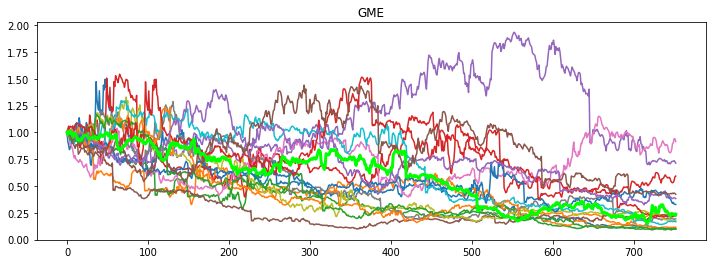

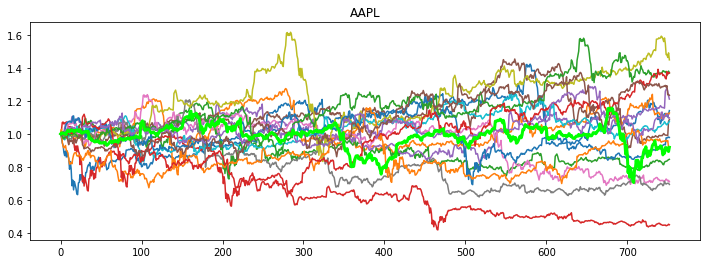

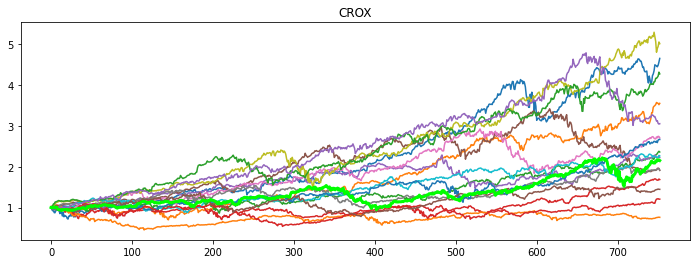

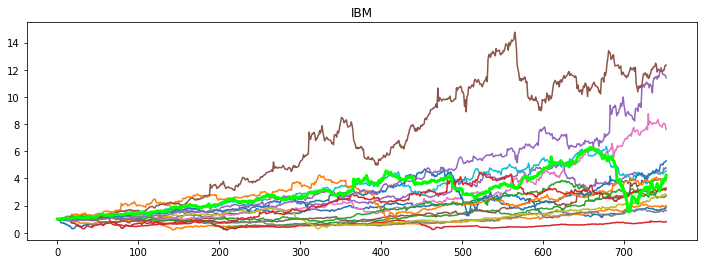

In [6]:
def match(a,b): #duplicate R's match(a,b) for lists
  if str(type(b)) != "<class 'list'>": raise Exception("Need 2nd arg as list") 
  l = [a.index(x) if x in b else None for x in a]
  res = [] 
  for val in l: 
    if val != None : 
      res.append(val) 
  return res
    
###%matplotlib widget
import matplotlib.pyplot as plt
def plotPaths(price_matrix,result,cols=None,col_idxs=None,limit=4):
  plt.rcParams["figure.figsize"] = [12,4]
  rng = range(0,min(limit,price_matrix.shape[1])) if col_idxs is None else col_idxs
  print(type(rng))
  print(rng)
  col_idx = 0
  for i in rng: #max out at 4 plots
    for j in range(result.shape[0]):
      plt.plot(result[j, i, :].get()/result[j, i, 0].get()) ###was:df['date'].values.get())#, result[i, 0, :].get())
    plt.plot(price_matrix[:, i].get()/price_matrix[0, i].get(), linewidth=3, color='lime') #MJBennett
    plt.title(cols[col_idx] if cols is not None else str(i))
    col_idx += 1
    plt.show()
    
picks = ['GME','AAPL','CROX','IBM']
col_idxs = match(cols,picks)
plotPaths(price_matrix,result,cols=picks,col_idxs=col_idxs)

### Sample points in the 3D result space to be sure that it is fully populated

In [7]:
print(price_matrix.shape, result.shape) #Before and after block bootstrapping
price_matrix[price_matrix.shape[0]-1,price_matrix.shape[1]-1],result[total_samples-1,
                                                result.shape[1]-1,result.shape[2]-1]

(753, 4266) (16, 4266, 753)


(array(140.970001), array(199.41287954))

### Observe paths for first security, security 0.

In [8]:
print(cols[0])
result[:,0,:].round(3)

CTBB


array([[19.84 , 19.604, 19.337, ..., 23.551, 23.814, 24.012],
       [19.84 , 19.866, 19.875, ..., 33.95 , 33.768, 33.78 ],
       [19.84 , 19.696, 19.662, ..., 18.728, 18.874, 18.84 ],
       ...,
       [19.84 , 19.911, 19.871, ..., 17.133, 17.149, 17.11 ],
       [19.84 , 19.831, 19.458, ..., 26.436, 26.2  , 26.724],
       [19.84 , 19.849, 19.849, ..., 24.432, 24.461, 24.5  ]])

### Unit test the run_boot_strap() function to be sure it is reusing price paths segments as expected.

[ 6 , 1 ] 6
(6, 2) (3, 2, 6) =====
sample 0 
 [[1.         0.66666667 0.66666667 1.33333333 0.66666667 0.44444444]
 [1.         0.66666667 0.66666667 1.33333333 0.66666667 0.44444444]
 [1.         0.66666667 0.66666667 1.33333333 0.66666667 0.44444444]]
********************
[1.  2.  2.  1.  1.  1.5] sample 1 
 [[[1.   1.   0.5  0.5  0.75 0.75]]

 [[1.   1.   0.5  0.5  0.75 0.75]]

 [[1.   1.   0.5  0.5  0.75 0.75]]]
********************
[1.  2.  2.  1.  1.  1.5] sample 1 
 [[[1.   1.   0.5  0.5  0.75 0.75]]

 [[1.   1.   0.5  0.5  0.75 0.75]]

 [[1.   1.   0.5  0.5  0.75 0.75]]]
<class 'range'>
range(0, 2)


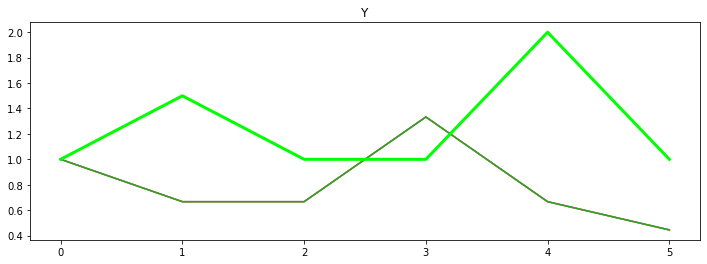

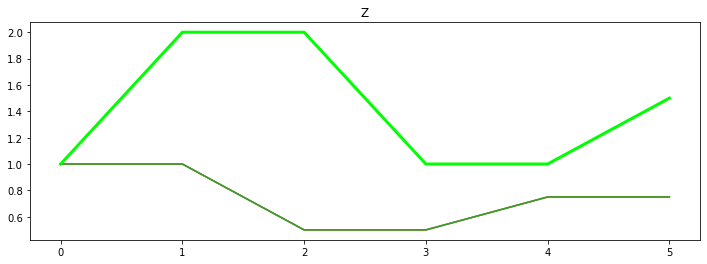

In [9]:
#unit test run_bootstrap() with ramp price series:

###output = run_sample_test(2, 2)
v = cupy.array([[1.0, 1.0], [1.5, 2.0], [1.0, 2.0], [1.0, 1.0], [2.0, 1.0], [1.0, 1.5]]) #len x assets
output = run_bootstrap(v, number_samples = 3, block_size = 4, number_of_threads = 1) #samples x assets x len

if False: #erase bootstraps relace w ones
    output[0,:,:] = cupy.ones((2,len(v[:,0])))
    output[1,:,:] = cupy.ones((2,len(v[:,0])))
    output[2,:,:] = cupy.ones((2,len(v[:,0])))
    print(output)

print(v.shape,output.shape,"=====")
print('sample 0 \n', output[:,0,:])
print(20*'*')
print(v[:,1],'sample 1 \n', output[:,1:])
print(20*'*')
print(v[:,1],'sample 1 \n', output[:,1:])

plotPaths(v,output,['Y','Z'])

In [10]:
def plotBoth(cputime,gputime,mat):
  plt.bar([0,1],[cputime,gputime],align='center',alpha=.5)
  plt.xticks([0,1],('CPU time','GPU time'))
  plt.title('speedup = '+
          str(np.round(cputime/gputime,2)) + ', shape = ' + str(mat.shape))
  plt.show()

### Reshape the results to be able to see adjacent price paths in a 2D data frame for hand validation

In [11]:
def result_reshape(result,result_wide): #CPU version
  for path in range(0,result.shape[0]):
    for sec in range(0,result.shape[1]):
      for day in range(0,result.shape[2]):
        result_wide[day,sec*result.shape[0]+path] = result[path,sec,day]

cputime=60.0 #default if not run

start = time.time()
result_wide = np.zeros((result.shape[2],result.shape[0]*result.shape[1]))       
if False: #Very long reshape without GPU!
    result_reshape(result,result_wide)
    cputime = time.time()-start
    print(cputime,'secs')
    pd.DataFrame(result_wide).head()         

0.0930790901184082 secs


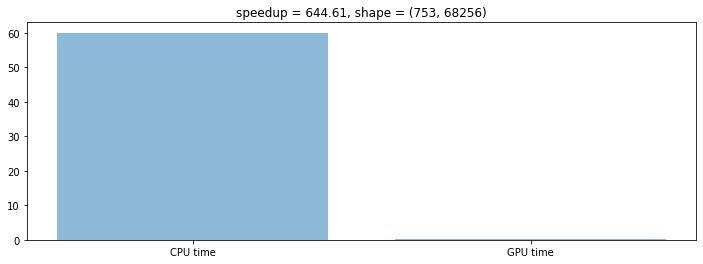

In [12]:
@cuda.jit()
def result_reshape_kernel(result,result_wide): #GPU version
  path = cuda.blockIdx.x*cuda.blockDim.x+cuda.threadIdx.x
  sec  = cuda.blockIdx.y*cuda.blockDim.y+cuda.threadIdx.y
  day  = cuda.blockIdx.z*cuda.blockDim.z+cuda.threadIdx.z
  if path < result.shape[0]:
    if sec < result.shape[1]:
      if day < result.shape[2]:
        result_wide[day,sec*result.shape[0]+path] = result[path,sec,day]

start = time.time()
result_wide = cupy.zeros((result.shape[2],result.shape[0]*result.shape[1]))
result_reshape_kernel[(total_samples,3200,960), (total_samples,8,8)](result,result_wide)
gputime = time.time()-start
print(gputime,'secs')
plotBoth(cputime,gputime,result_wide)
#del result
#cudf.DataFrame(result_wide[0:4,:]).head(5) #use data frame for nice head() display

### Convert all our newly simulated price paths to log returns into a 2D matrix called R

In [13]:
import cudf
import cupy
from cupy import log,diff
from numba import cuda

@cuda.jit()
def findR(prices,R,ppp):
  #compute log returns by column j:
  j = cuda.blockIdx.x * cuda.blockDim.x+cuda.threadIdx.x
  #for j in range(0,pp):
  if j < ppp:
    for i in range(0,prices.shape[0]-1):
      R[i,j] = math.log(prices[i+1,j]) - math.log(prices[i,j]) #cupy.diff(cupy.log(prices[:,j]))

ppp = pp*total_samples
print('pp',pp,'ppp',ppp)    
R_result = cupy.zeros([result_wide.shape[0]-1, result_wide.shape[1]]).astype(np.float32)
start = time.time()
findR[(blockSz,1,1), (256,1,1)](result_wide,R_result,ppp)
print(time.time()-start,'secs')
#cudf.DataFrame(R[0:4,:]).tail(5)
R_result.shape,R_result[0,ppp//16-1],R_result[0,ppp//16],R_result[0,ppp//2-1],\
    math.isclose(float(R_result[0,ppp-1]),math.log(result_wide[1,ppp-1]/result_wide[0,ppp-1]),abs_tol=.00001)

pp 4266 ppp 68256
0.08574295043945312 secs


((752, 68256),
 array(0.05380781, dtype=float32),
 array(0.09508345, dtype=float32),
 array(0.024846, dtype=float32),
 False)

### Find all the Sharpe Ratios in mass as in Part 1

In [14]:
@cuda.jit()
def findSharpeRatiosNumba2(R, meanv, sdevv, SR, Nm1):
  #for j in range(0,pp): 
  j = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
  if j < R.shape[1]:
    for i in range(0,Nm1): #compute pp means
        meanv[j] += R[i,j]
    meanv[j] /= Nm1
    sdevv[j] = 0.0
    for i in range(0,Nm1): #compute pp sdevs
        sdevv[j] += (R[i,j]-meanv[j])**2
    sdevv[j] /= Nm1
    sdevv[j] = math.sqrt(sdevv[j])
    SR[j]    = meanv[j]/sdevv[j]#omit for PSR: math.sqrt(252.0) 

### We experiment with and are interested in the [Probabilistic Sharpe Ratio (PSR)](https://quantdare.com/probabilistic-sharpe-ratio/)

In [15]:
import scipy
from scipy.stats import skew,kurtosis
scipy.stats.norm.cdf(scipy.stats.norm.ppf(0.95))

@cuda.jit()
def findSRforPSR(R, SR, savesdevsum, SR_sdevv, meanv, sdevv, skewv, kurtv,
                 Nm1, ppp, SR_benchmark=0.0):
  #for j in range(0,pp): 
  j = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x 
  if j < ppp:
    for i in range(0,Nm1): #compute ppp means
      meanv[j] += R[i,j]
    meanv[j] /= Nm1 #Nm1 is number of log returns for N prices
    sdevv[j] = 0.0; skewv[j] = 0.0; kurtv[j] = 0.0
    for i in range(0,Nm1): #compute ppp sdevs
      sdevv[j] += (R[i,j]-meanv[j])**2
    savesdevsum[j] = sdevv[j]
    sdevv[j] /= Nm1
    sdevv[j] = math.sqrt(sdevv[j])
    for i in range(0,Nm1): 
        #https://www.cambridge.org/LaptopLab
        skewv[j] += ((R[i,j]-meanv[j])/sdevv[j])**3
        kurtv[j] += ((R[i,j]-meanv[j])/sdevv[j])**4
    sdevv[j] = math.sqrt(savesdevsum[j]/(Nm1-1))
    SR[j]    = meanv[j]/sdevv[j]#omit for now: math.sqrt(252.0)

    skewv[j] /= Nm1
    kurtv[j] /= Nm1
    SR_sdevv[j] = math.sqrt((1 + (0.5 * SR[j] ** 2) - (skewv[j] * SR[j]) +
                        (((kurtv[j] - 3) / 4) * SR[j] ** 2)) / Nm1)
    
#https://quantdare.com/probabilistic-sharpe-ratio/
def findPSR(SR, SR_sdevv, PSR, ppp, SR_benchmark):
  SR = SR.get(); SR_sdevv = SR_sdevv.get()
  for j in range(0,ppp):    
    PSR[j] = scipy.stats.norm.cdf((SR[j] - SR_benchmark) / SR_sdevv[j]) 

### Validate implementation of findSRforPSR() and findPSR() with just 2 cases of our own

In [16]:
#our unit test for skew and kurtosis for findSRforPSR:
meanv    = cupy.zeros(2).astype(cupy.float32)
sdevv    = cupy.zeros(2).astype(cupy.float32)
skewv    = cupy.zeros(2).astype(cupy.float32)
kurtv    = cupy.zeros(2).astype(cupy.float32)
SR_sdevv = cupy.zeros(2).astype(cupy.float32)                         
SR       = cupy.zeros(2).astype(cupy.float32)
savesdevsum = cupy.zeros(2).astype(cupy.float32)
PSR      = np.zeros(2).astype(np.float32)

logreturns = cupy.array([[-0.0251,-0.0886,-0.0382,-0.0437,-0.0939,-0.0487,-0.0155,-0.0678],
            [0.0586,0.0913,0.0455,0.0265,0.0267,0.0871,0.062,0.008]], cupy.float32).T

findSRforPSR[(blockSz,1,1), (256,1,1)](logreturns, SR, savesdevsum, SR_sdevv, meanv, sdevv,\
    skewv, kurtv, logreturns.shape[0], 2, 0.0)
findPSR(SR, SR_sdevv, PSR, 2, 0.0)

SR,SR_sdevv,meanv,sdevv,skewv,kurtv,PSR.round(5) #These values can be hand calc'd and compared

(array([-1.8517224,  1.7073866], dtype=float32),
 array([0.37646192, 0.42740628], dtype=float32),
 array([-0.0526875,  0.0507125], dtype=float32),
 array([0.02845324, 0.02970183], dtype=float32),
 array([-0.28848535,  0.06332409], dtype=float32),
 array([1.7792449, 1.7814678], dtype=float32),
 array([0.     , 0.99997], dtype=float32))

### Validate use of the SR std. deviation (SR_sdevv) and Prob SR (PSR) formula from quantdare:
https://quantdare.com/probabilistic-sharpe-ratio/

In [17]:
N = 52; Nm1 = N-1; SR_benchmark = 0.0 #Their test uses these params

meanRet = cupy.array([.001447,.00136],cupy.float32)
sdevRet = cupy.array([.006394,.00633],cupy.float32)
skewv = cupy.array([-.778757,.95],cupy.float32)
kurtv = cupy.array([2.873831,5.92],cupy.float32)
SR    = cupy.zeros(2).astype(cupy.float32)
SR_sdevv = cupy.zeros(2).astype(cupy.float32)
PSR = np.zeros(2).astype(np.float32)

SR_2D_sdev = cupy.array([.1534,.1293],cupy.float32)
print('SD computed =',SR.round(4))
print('SD annualized computed =',SR*math.sqrt(N)) #weekly to ann
for j in range(0,2):
  SR[j] = meanRet[j]/sdevRet[j]
  SR_sdevv[j] = math.sqrt((1 + (0.5 * SR[j] ** 2) - (skewv[j] * SR[j]) +
                        (((kurtv[j] - 3) / 4) * SR[j] ** 2)) / Nm1)
  PSR[j] = scipy.stats.norm.cdf((SR.get()[j] - SR_benchmark) / SR_sdevv.get()[j]) 
  print(j,': ',SR[j].round(4),PSR[j].round(4)) #These values can be compared directly to quantdare page

SD computed = [0. 0.]
SD annualized computed = [0. 0.]
0 :  0.2263 0.9299
1 :  0.2148 0.9517


In [18]:
ppp = R_result.shape[1]
meanv    = cupy.zeros(ppp).astype(cupy.float32)
sdevv    = cupy.zeros(ppp).astype(cupy.float32)
skewv    = cupy.zeros(ppp).astype(cupy.float32)
kurtv    = cupy.zeros(ppp).astype(cupy.float32)
SR_sdevv = cupy.zeros(ppp).astype(cupy.float32)                         
SR       = cupy.zeros(ppp).astype(cupy.float32)
savesdevsum = cupy.zeros(ppp).astype(cupy.float32) 
PSR      = np.zeros(ppp).astype(np.float32)

#First time is mainly to compile it:
print(R_result.shape)
start = time.time()
findSRforPSR[(blockSz,1,1), (256,1,1)](R_result, SR, savesdevsum, SR_sdevv, meanv, sdevv,\
    skewv, kurtv, R_result.shape[0]-1, ppp, 0.0)
print(time.time()-start,'secs')
start = time.time()
if True:
    findPSR(SR, SR_sdevv, PSR, ppp, 0.0)
    PSR = cupy.asarray(PSR) #back to GPU
print(time.time()-start,'secs')

#cudf.DataFrame(PSR).head(4) #GME,CXH SRs
R_result[0,pp//16-1],R_result[0,pp//16],R_result[0,pp//2-1],R_result[0,pp//1-1],sdevv[pp//16-1],sdevv[pp//16],pp

(752, 68256)
0.24535560607910156 secs
4.3606486320495605 secs


(array(0.00611337, dtype=float32),
 array(-0.00165768, dtype=float32),
 array(0.00654871, dtype=float32),
 array(0.05380781, dtype=float32),
 array(0.01161881, dtype=float32),
 array(0.01984625, dtype=float32),
 4266)

### Ballpark inspection: locate GME and then also AAPL,CROX,EXAS which we know do well in SR

[763, 1793, 2268, 3842] [12208, 28688, 36288, 61472]
[-0.0708  0.0082  0.1001  0.0208]
[[12208, 12209, 12210, 12211, 12212, 12213, 12214, 12215, 12216, 12217, 12218, 12219, 12220, 12221, 12222, 12223], [28688, 28689, 28690, 28691, 28692, 28693, 28694, 28695, 28696, 28697, 28698, 28699, 28700, 28701, 28702, 28703], [36288, 36289, 36290, 36291, 36292, 36293, 36294, 36295, 36296, 36297, 36298, 36299, 36300, 36301, 36302, 36303], [61472, 61473, 61474, 61475, 61476, 61477, 61478, 61479, 61480, 61481, 61482, 61483, 61484, 61485, 61486, 61487]]
[12208, 12209, 12210, 12211, 12212, 12213, 12214, 12215, 12216, 12217, 12218, 12219, 12220, 12221, 12222, 12223, 28688, 28689, 28690, 28691, 28692, 28693, 28694, 28695, 28696, 28697, 28698, 28699, 28700, 28701, 28702, 28703, 36288, 36289, 36290, 36291, 36292, 36293, 36294, 36295, 36296, 36297, 36298, 36299, 36300, 36301, 36302, 36303, 61472, 61473, 61474, 61475, 61476, 61477, 61478, 61479, 61480, 61481, 61482, 61483, 61484, 61485, 61486, 61487]

 16 bo

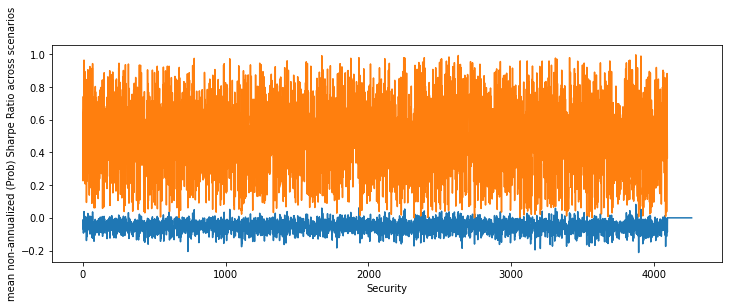

In [19]:
#Must extend idxs based upon total_samples
path_idxs = [total_samples*i for i in col_idxs]
print(col_idxs,path_idxs)
print(SR[path_idxs].round(4))

path_idxs_neighbors = [[i for i in range(path_idx,path_idx+total_samples)] for path_idx in path_idxs]
print(path_idxs_neighbors)

flatten = lambda t: [item for sublist in t for item in sublist]
path_idxs_neighbors = flatten(path_idxs_neighbors)
print(path_idxs_neighbors)
print('\n',total_samples,'bootstrapped SRs per security annualized:')
print(SR[path_idxs_neighbors].round(4))

#reshape so that we can summarize statistics:

SR_2D  = cupy.reshape(SR, (-1,total_samples))
SRmean = cupy.zeros([pp]).astype(cupy.float32)
SRmean = [float(SR[i*total_samples:(i+1)*total_samples].min()) for i in range(0,pp)]
###SRprob = cupy.zeros(SR_2D.shape[0])
###(SR,ncol=SR.shape[0]//total_samples)
#Examine across all securities:
plt.plot(np.arange(pp), np.array(SRmean))
plt.xlabel('Security')
plt.ylabel('mean non-annualized (Prob) Sharpe Ratio across scenarios')

PSRmean = cupy.zeros([pp]).astype(cupy.float32)
PSRmean = [float(PSR[i*total_samples:(i+1)*total_samples].mean()) for i in range(0,pp)]

###SRSR = [SRmean[i]/SRsdev[i] for i in range(0,pp//total_samples)]
###print('SR annualized means',[float(SRmean[i]) for i in col_idxs])
###print('SR annualized stdevs',[float(SRsdev[i]) for i in col_idxs])

#Examine across all securities:
plt.plot(np.arange(pp), np.array(PSRmean))

Populating the interactive namespace from numpy and matplotlib


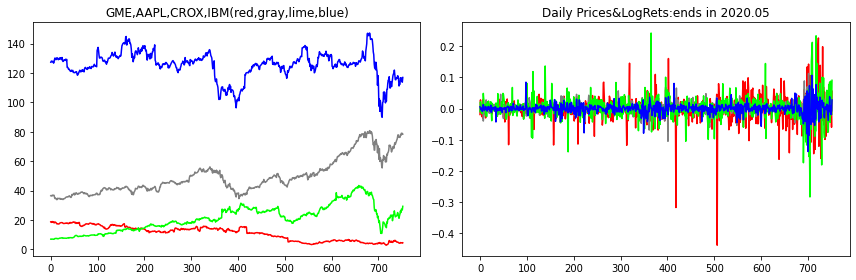

In [20]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 4)

def plotSec(symbs,lab,prices,R):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  axList = axes.flatten()
  axIdx = 0; colors = ['red','gray','lime','blue']
  for symb in symbs:
    idx = np.where(np.array(lab)==symb)[0][0]
    axList[0].set_title(','.join(symbs)+'('+','.join(colors)+')')
    axList[0].plot(range(0,prices.shape[0]), prices[:,idx].get(),color=colors[axIdx])
    axList[1].set_title("Daily Prices&LogRets:ends in "+'.'.join(fname1.split('/')[1].split('.')[1:3]))
    #plt.subplot(1, 2, 2)
    axList[1].plot(range(0,prices.shape[0]-1),
                   np.round(R[:,idx].get(),3),color=colors[axIdx])
    axIdx += 1
  fig.tight_layout()
  plt.show()
    
Rpicks = cupy.zeros([prices.shape[0]-1, pp]).astype(np.float32)
findR[(blockSz,1,1), (256,1,1)](prices,Rpicks,pp)
plotSec(picks,cols,prices,Rpicks)

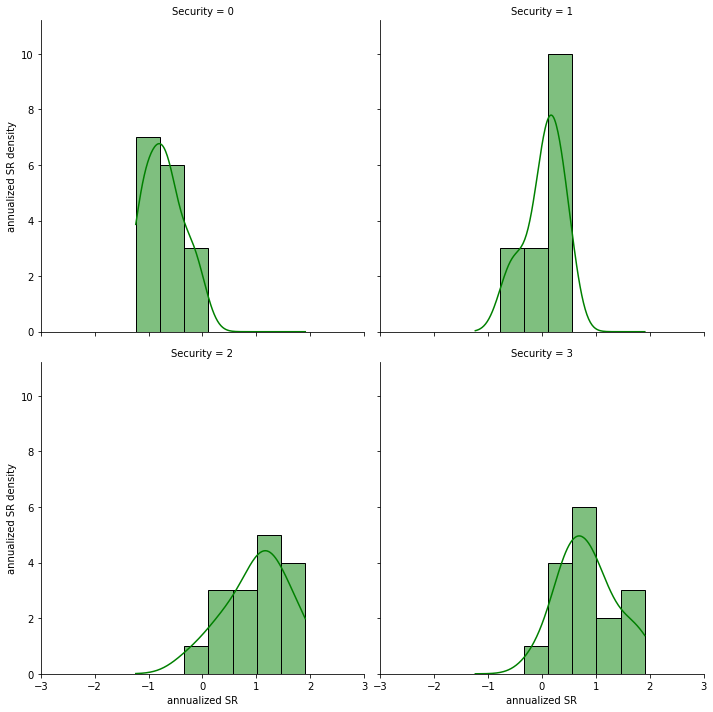

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# data
#stat_list = [[0.3,0.5,0.7,0.3,0.5], [0.2,0.1,0.9,0.7,0.4], [0.9,0.8,0.7,0.6,0.5], [0.2,0.6,0.75,0.87,0.91], [0.2,0.3,0.8,0.9,0.3], [0.2,0.3,0.8,0.87,0.92]]
picks = ['GME','CROX','AAPL','IBM']
col_idxs = match(cols,picks)
###col_idxs = [0,1,2]
###SR_2D = cupy.array([[1,2,3],[3,4,6],[5,6,7]]).astype(cupy.float32)
###SRSR  = SR_2D.copy()
stat_list = [list(SR_2D[sec,:].get()*math.sqrt(252)) for sec in col_idxs]

# load the data into pandas and then transpose it for the correct column data
df = pd.DataFrame(stat_list).T

# name the columns; specify a layer number
# append to label as the SR of the SR
###df.columns = [str(i)+'::'+str(SRSR[i].round(3)) for i in col_idxs]
               
# now stack the data into a long (tidy) format
dfl = df.stack().reset_index(level=1).rename(columns={'level_1': 'Security', 0: 'annualized SR'})

# plot a displot
g = sns.displot(data=dfl, x='annualized SR', col='Security', col_wrap=2, kde=True, color='green')
#plt.axvline([0.0], color='red') #vertical lines desired
g.set_axis_labels(y_var='annualized SR density')
g.set(xlim=(-3.0, 3.0), ylim=(0, float(total_samples*.7)))

### Skim off the top k best

In [22]:
k = 12
srdf = cudf.DataFrame(
    {'ticker':cols,'SRmean':SRmean})
srdf = srdf.sort_values(by=['SRmean'], ascending=False)
srdf['annSRmean'] = srdf['SRmean']*sqrt(252.0)

### Examine paths of the top k

[780, 1029, 1674, 1934, 2248, 2255, 2392, 3218, 3311, 3832, 3874, 3910] ['MSCI', 'SHOP', 'FCN', 'DG', 'ARWR', 'AUDC', 'LULU', 'LUNA', 'OKTA', 'FRPT', 'ENPH', 'MRTX']
<class 'range'>
range(0, 12)


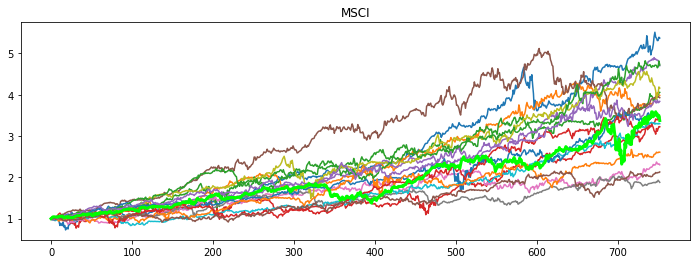

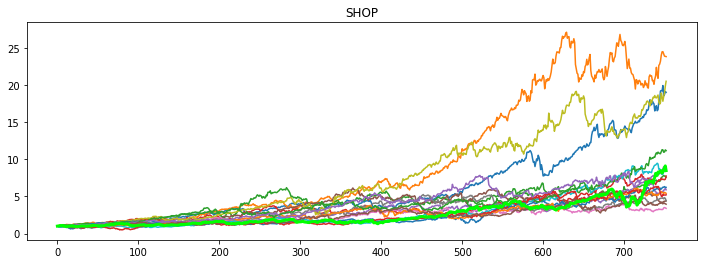

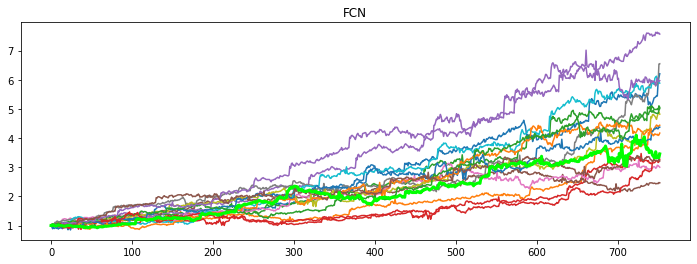

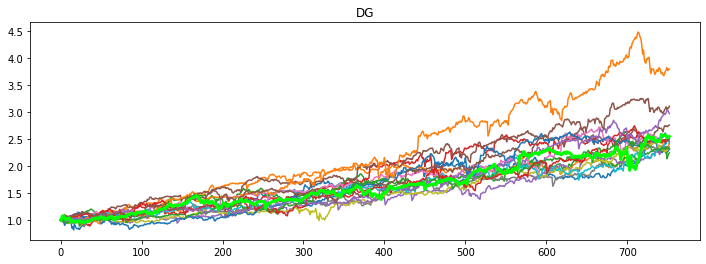

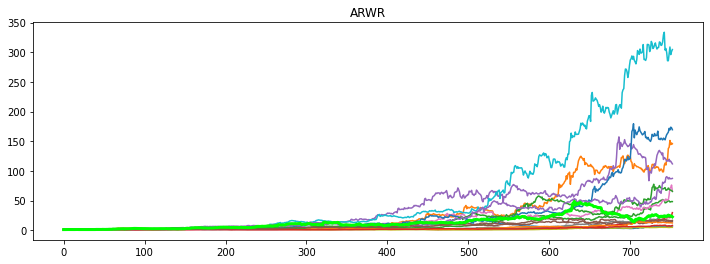

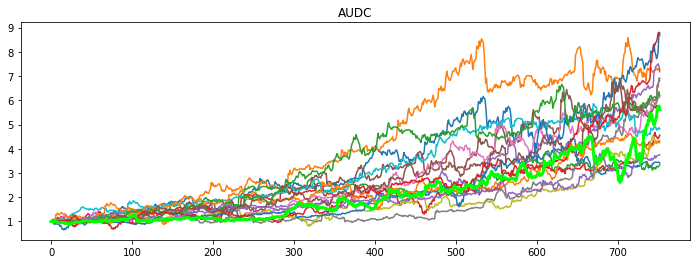

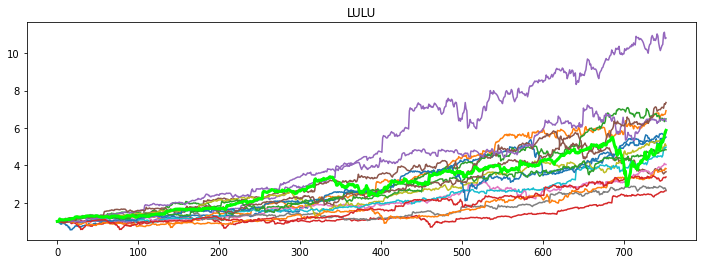

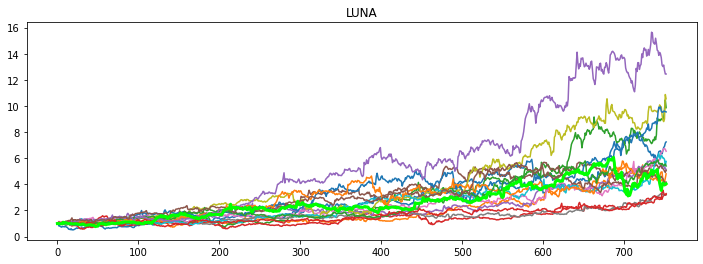

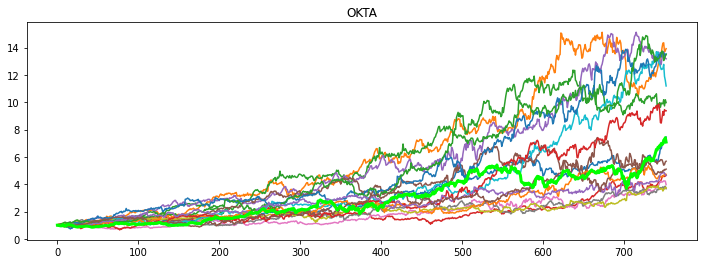

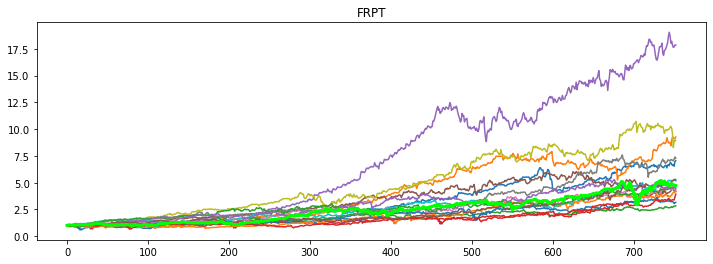

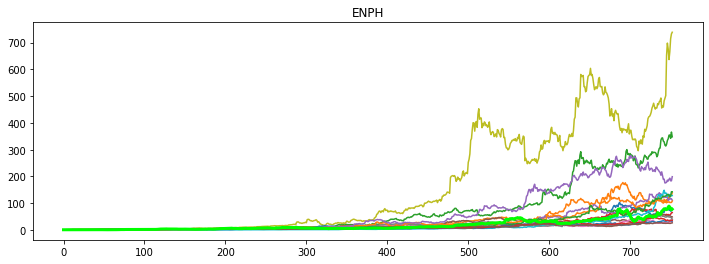

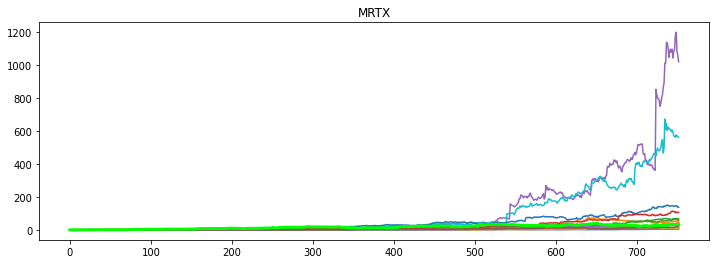

['MSCI',
 'SHOP',
 'FCN',
 'DG',
 'ARWR',
 'AUDC',
 'LULU',
 'LUNA',
 'OKTA',
 'FRPT',
 'ENPH',
 'MRTX']

In [23]:
idxVec=match(cols,srdf['ticker'].head(k).to_arrow().to_pylist())
colList = [cols[i] for i in idxVec]
print(idxVec,colList)
plotPaths(price_matrix[:,idxVec],result[:,idxVec,:],colList,limit=k)

topCols = [cols[i] for i in idxVec]
topCols

In [24]:
%%script false --no-raise-error
#Another way to skim off top k Sstock by SR
k = 12

def findTopSRcandid(SR,k):
  idxVec = list(); found = 0
  while found < k:
    idx = np.argmax(SR)
    print(cols[idx],SR[idx])
    if not isnan(SR[idx]):
      idxVec.append(idx) 
      SR[idx] = -10000 #disqualify SR[idx]
      found += 1
  return idxVec

start = time.time()
idxVec = findTopSRcandid(PSRmean,k) #was:SRSR
end   = time.time()
print(idxVec,pp)
print("%fs" % ((end-start)))
topCols = [cols[i] for i in idxVec]
topCols

### Perform a basic check: Filter out so no flat lined prices with zero log returns

In [25]:
R = cupy.zeros([prices.shape[0]-1, pp]).astype(np.float32)
findR[(blockSz,1,1), (256,1,1)](prices,R,pp)

validMask = [int(sum(R[:,np.array(idx)]==0.0))<50 for idx in idxVec]
print(validMask)
idxVec = list(np.array(idxVec)[validMask]) #Remove securities flat-lined price quotes
investment_tickers = [cols[i] for i in idxVec]
investment_tickers#,(prices[prices.shape[0]-1,idxVec]),prices[(prices.shape[0]-1)//2,idxVec]

[True, True, True, True, True, True, True, False, True, True, True, True]


['MSCI',
 'SHOP',
 'FCN',
 'DG',
 'ARWR',
 'AUDC',
 'LULU',
 'OKTA',
 'FRPT',
 'ENPH',
 'MRTX']

In [26]:
investment_tickers_df = cudf.DataFrame({'ticker': investment_tickers})
result_df = cudf.merge(investment_tickers_df, srdf, on=["ticker"])
investment_tickers_df
result_df = result_df.sort_values(by=['SRmean'], ascending=False)

### Examine remaining top k securities: plott actual price paths

Populating the interactive namespace from numpy and matplotlib
['MSCI', 'SHOP', 'FCN', 'DG', 'ARWR', 'AUDC', 'LULU', 'LUNA', 'OKTA', 'FRPT', 'ENPH', 'MRTX']
0 4
0.3421127


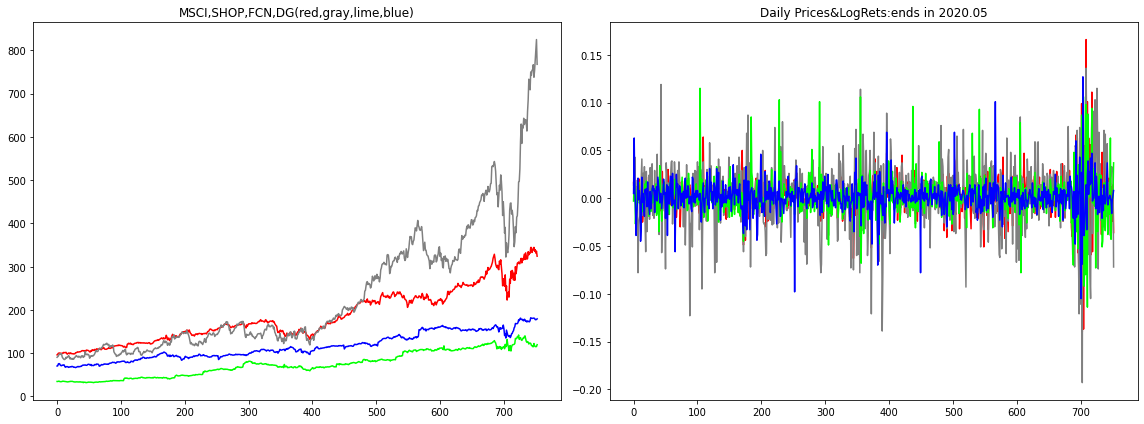

4 8
0.25992766


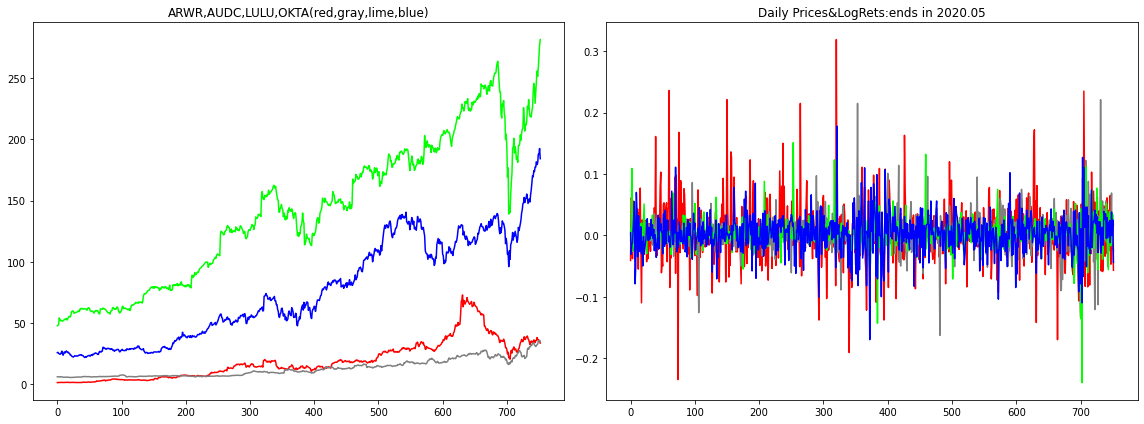

8 12
0.85830885


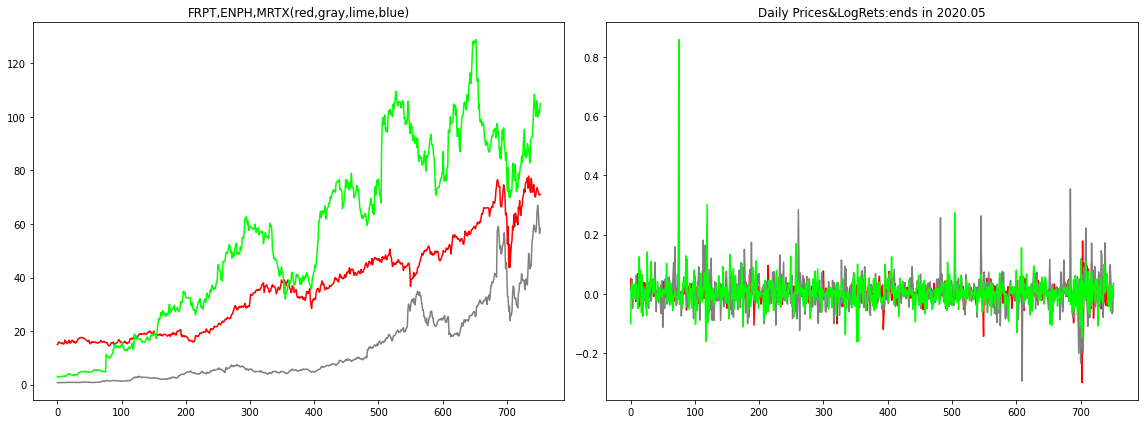

([780, 1029, 1674, 1934, 2248, 2255, 2392, 3311, 3832, 3874, 3910],
 ['MSCI',
  'SHOP',
  'FCN',
  'DG',
  'ARWR',
  'AUDC',
  'LULU',
  'OKTA',
  'FRPT',
  'ENPH',
  'MRTX'])

In [27]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 6)

print(topCols)
for i in range(len(investment_tickers)):
  if i % 4 == 0:
    print(i,i+4,)
    print(PSR[idxVec[i]],)
    #plotSec(picks,cols,prices,Rpicks)
    plotSec(investment_tickers[i:(i+4)],cols,prices,R)
idxVec,investment_tickers

In [28]:
#if len(match(investment_tickers,['BST'])) > 0: investment_tickers.remove('BST')
investment_tickers

['MSCI',
 'SHOP',
 'FCN',
 'DG',
 'ARWR',
 'AUDC',
 'LULU',
 'OKTA',
 'FRPT',
 'ENPH',
 'MRTX']

### Roll time forward one quarter to see our portfolio performance

In [29]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

fname1 = "data/MVO3.2017.11/NYSE/prices.csv"
fname2 = "data/MVO3.2017.11/NASDAQ/prices.csv"

fname1 = "data/MVO3.2018.03/NYSE/prices.csv"
fname2 = "data/MVO3.2018.03/NASDAQ/prices.csv"

fname1 = "data/MVO3.2018.05/NYSE/prices.csv"
fname2 = "data/MVO3.2018.05/NASDAQ/prices.csv"

fname1 = "data/MVO3.2018.08/NYSE/prices.csv"
fname2 = "data/MVO3.2018.08/NASDAQ/prices.csv"

fname1 = "data/MVO3.2018.11/NYSE/prices.csv"
fname2 = "data/MVO3.2018.11/NASDAQ/prices.csv"

fname1 = "data/MVO3.2019.02/NYSE/prices.csv"
fname2 = "data/MVO3.2019.02/NASDAQ/prices.csv"

fname1 = "data/MVO3.2019.05/NYSE/prices.csv"
fname2 = "data/MVO3.2019.05/NASDAQ/prices.csv"

fname1 = "data/MVO3.2019.08/NYSE/prices.csv"
fname2 = "data/MVO3.2019.08/NASDAQ/prices.csv"

fname1 = "data/MVO3.2019.11/NYSE/prices.csv"
fname2 = "data/MVO3.2019.11/NASDAQ/prices.csv"

fname1 = "data/MVO3.2020.02/NYSE/prices.csv"
fname2 = "data/MVO3.2020.02/NASDAQ/prices.csv"

fname1 = "data/MVO3.2020.05/NYSE/prices.csv"
fname2 = "data/MVO3.2020.05/NASDAQ/prices.csv"

fname1 = "data/MVO3.2020.08/NYSE/prices.csv"
fname2 = "data/MVO3.2020.08/NASDAQ/prices.csv"

#merge the ticker label sets:
df2 = readPrices()
prices2 = df2.values
cols = df2.columns.values.tolist()
print(df2.shape)
df2[investment_tickers]

[]
(755, 4314)


,MSCI,SHOP,FCN,DG,ARWR,AUDC,LULU,OKTA,FRPT,ENPH,MRTX
0,109.833893,103.790001,32.900002,74.551750,2.740000,6.274549,60.130001,24.459999,15.700000,0.920000,5.400000
1,108.957062,104.370003,33.099998,74.089241,2.640000,6.237256,58.320000,24.490000,15.600000,0.920000,5.550000
2,108.870369,108.440002,33.250000,73.935059,2.740000,6.377105,57.610001,26.309999,15.700000,0.950000,5.600000
3,110.431297,110.919998,33.910000,69.916954,2.800000,6.516953,57.549999,26.990000,15.850000,0.920000,5.400000
4,111.240669,110.860001,33.990002,69.897697,2.860000,6.507630,61.689999,26.590000,16.150000,0.980000,5.100000
...,...,...,...,...,...,...,...,...,...,...,...
750,367.362183,1039.619995,117.949997,197.125336,43.060001,34.643806,366.420013,211.029999,115.000000,73.089996,143.839996
751,362.331024,1021.119995,116.070000,198.251480,42.490002,34.086800,368.750000,208.389999,113.650002,73.139999,144.990005
752,362.629913,999.320007,116.889999,197.643570,42.860001,32.744015,376.309998,205.119995,113.800003,73.360001,148.830002
753,364.164154,1037.189941,116.500000,197.982407,43.330002,33.330860,378.500000,209.529999,113.449997,75.930000,148.589996


In [30]:
N = len(idxVec)
w = cupy.asarray(np.resize((1/N), N))
w

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

In [31]:
one_quarter = 62
buy_prices = df2[investment_tickers].iloc[df2.shape[0]-1-one_quarter]
print(buy_prices) #.sum())
now_prices = df2[investment_tickers].iloc[df2.shape[0]-1]
print(now_prices) #.sum())
print(now_prices-buy_prices)
df2[investment_tickers].iloc[(df2.shape[0]-1-one_quarter):(df2.shape[0]-one_quarter)]

MSCI    326.900909
SHOP    757.799988
FCN     120.459999
DG      190.494156
ARWR     32.240002
AUDC     36.314293
LULU    300.100006
OKTA    195.580002
FRPT     77.180000
ENPH     58.189999
MRTX     99.190002
Name: 692, dtype: float64
MSCI     370.211487
SHOP    1089.329956
FCN      116.690002
DG       203.393875
ARWR      42.369999
AUDC      32.425724
LULU     381.500000
OKTA     224.139999
FRPT     112.589996
ENPH      75.239998
MRTX     148.910004
Name: 754, dtype: float64
MSCI     43.310578
SHOP    331.529968
FCN      -3.769997
DG       12.899719
ARWR     10.129997
AUDC     -3.888569
LULU     81.399994
OKTA     28.559997
FRPT     35.409996
ENPH     17.049999
MRTX     49.720002
dtype: float64


,MSCI,SHOP,FCN,DG,ARWR,AUDC,LULU,OKTA,FRPT,ENPH,MRTX
692,326.900909,757.799988,120.459999,190.494156,32.240002,36.314293,300.100006,195.580002,77.18,58.189999,99.190002


### Compute gross return vector and find the mean for equally weighting each security

In [32]:
print(mean(now_prices/buy_prices)) #gross return
df2[investment_tickers].iloc[(df2.shape[0]-1):(df2.shape[0])] #gross returns > 1.0 are profitable

1.2258052131035242


,MSCI,SHOP,FCN,DG,ARWR,AUDC,LULU,OKTA,FRPT,ENPH,MRTX
754,370.211487,1089.329956,116.690002,203.393875,42.369999,32.425724,381.5,224.139999,112.589996,75.239998,148.910004


           Measuring Accuracy of Quarterly Investment Performance: Net Returns
      Middle Strategy Block Bootstrap-Sampled Paths from Daily Market Historical Data


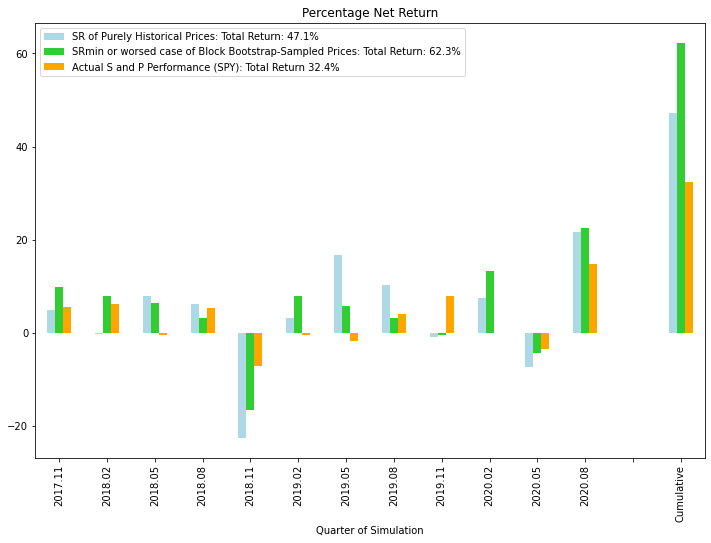

In [33]:
#Calc'd outide notebook:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,8]
#These timings are current as of Sep 2, 2020 SRmin last 2021.02 35.5 cannot repro not SR 14.2
data = [[4.9,-.2,8,6.2,-22.6,3.2,  16.7,10.2,-.9,7.4, -7.4, 21.6, 0.0, 47.1],
[9.9,   7.8,   6.4,   3.1, -16.6,   7.8,   5.8,   3.1,  -0.5,  13.2,  -4.4,  22.6, 0.0, 62.3],#SRmin  
[5.6,6.1,-.4,5.26,-7.2,-.4,  -1.7,4.0,7.8,-.1, -3.4,14.7, 0.0, 32.4]]

steps = ['2017.11', '2018.02', '2018.05', '2018.08', '2018.11', '2019.02',
    '2019.05', '2019.08', '2019.11', '2020.02', '2020.05', '2020.08','','Cumulative']

DF = pd.DataFrame({'SR of Purely Historical Prices: Total Return: 47.1%': data[0],
                   'SRmin or worsed case of Block Bootstrap-Sampled Prices: Total Return: 62.3%': data[1],
                   'Actual S and P Performance (SPY): Total Return 32.4%': data[2]}, index=steps)
dict = {"Purely Historical Prices": "lightblue",
    "Synthetically Generated Prices": "limegreen","S and P Performance (SPY Index)": "orange"}
ax = DF.plot.bar(color=dict.values())
ax.set_title('Percentage Net Return')
ax.set_xlabel('Quarter of Simulation')
print("           Measuring Accuracy of Quarterly Investment Performance: Net Returns")
print("      Middle Strategy Block Bootstrap-Sampled Paths from Daily Market Historical Data")